In [1]:
import pandas as pd
from gensim.models import FastText


C:\Users\Andreas\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Andreas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\Andreas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.noijjg62emaszi6nyurl6jbkm4evbgm7.gfortran-win_amd64.dll
C:\Users\Andreas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
df = pd.read_hdf("../datasets/science.h5", key="science")

In [3]:
model_sent = FastText.load("../models/subreddit_level/fasttext_science_senti.bin")

In [4]:
NRC = pd.read_csv('../datasets/NRC-VAD-Lexicon.txt', sep="\t", header=None, names=["Words", "valence", "arousal", "dominance"])

In [5]:
token_list = df["token_list"].tolist()
flatlist = [item for sublist in token_list for item in sublist]

In [47]:
def identify_weigths(flat_list):
    from collections import Counter
    female=["sister" , "female" , "woman" , "girl" , "daughter" , "she" , "hers" , "her"]
    male=["brother" , "male" , "man" , "boy" , "son" , "he" , "his" , "him","men"] 
   
    tokens = [item for sublist in flat_list for item in sublist]
    term_list_woman = []
    for i in tokens:
        if i in female:
            term_list_woman.append(i)
    counter = Counter(term_list_woman)
    
    liste_woman = []
    weights = []
    
    for i in counter:
        if counter[i] > 100:
            liste_woman.append(i)
            weights.append(counter[i])
            
    term_list_man = []
    for i in tokens:
        if i in male:
            term_list_man.append(i)
    counter = Counter(term_list_man)
    
    liste_man = []
    weights_man = []
    
    for i in counter:
        if counter[i] > 100:
            liste_man.append(i)
            weights_man.append(counter[i])
    
    return [liste_woman, weights], [liste_man, weights_man] 

In [48]:
woman_terms_freq, man_terms_freq = identify_weigths(flatlist)

In [49]:
woman_terms_freq, man_terms_freq

([['woman', 'she', 'female', 'sister', 'girl', 'her', 'daughter'],
  [13813, 12793, 2531, 1862, 1678, 4785, 684]],
 [['man', 'boy', 'son', 'he', 'male', 'brother', 'his', 'men'],
  [13830, 1464, 918, 22803, 3182, 771, 8436, 134]])

In [50]:
def calculate_centroid_vectors(woman_terms_freq, man_terms_freq, model, NRC, n_words):
    import numpy as np
    word_vectors = model.wv
    centroid_woman = np.ma.average([word_vectors[w] for w in woman_terms_freq[0]], weights= woman_terms_freq[1] ,axis=0)

    vector_woman = word_vectors.similar_by_vector(centroid_woman,topn=n_words)
    
    liste_woman = []
    for i in vector_woman:
        liste_woman.append(i[0])
    
    print("Top 10 (woman)", liste_woman[:10])
    
    intersection_woman = list(set(liste_woman) & set(NRC["Words"]))
    
    intersection_woman_ordererd = []
    for i in vector_woman:
        if i[0] in intersection_woman:
            intersection_woman_ordererd.append(i[0])
    
    df_intersection_woman = pd.DataFrame(intersection_woman_ordererd, columns=["Words"])
    df_intersection_woman = df_intersection_woman.merge(NRC, how="left", left_on="Words", right_on="Words")
    
    
    
    centroid_man = np.ma.average([word_vectors[w] for w in man_terms_freq[0]], weights= man_terms_freq[1] ,axis=0)

    vector_man = word_vectors.similar_by_vector(centroid_man,topn=n_words)
    
    
    liste_man = []
    for i in vector_man:
        liste_man.append(i[0])
    
    print("Top 10 (man)", liste_man[:10])
    
    intersection_man = list(set(liste_man) & set(NRC["Words"]))
    
    intersection_man_ordererd = []
    for i in vector_man:
        if i[0] in intersection_man:
            intersection_man_ordererd.append(i[0])
    
    df_intersection_man = pd.DataFrame(intersection_man_ordererd, columns=["Words"])
    df_intersection_man = df_intersection_man.merge(NRC, how="left", left_on="Words", right_on="Words")
    
    
    return df_intersection_woman, df_intersection_man, liste_woman, liste_man

In [51]:
df_NRC_woman , df_NRC_man , liste_woman, liste_man= calculate_centroid_vectors(woman_terms_freq, man_terms_freq, model_sent, NRC, 500)


Top 10 (woman) ['she', 'wife', 'herself', 'woman', 'her', 'girlfriend', 'daughter', 'husband', 'mom', 'pregnant']
Top 10 (man) ['he', 'his', 'son', 'husband', 'girlfriend', 'dad', 'guy', 'wife', 'father', 'boyfriend']


In [52]:
df_NRC_man.sort_values("valence").head()

,Words,valence,arousal,dominance
37,hell,0.020,0.918,0.565
240,misbehave,0.020,0.847,0.304
157,unfaithful,0.031,0.806,0.298
304,die,0.031,0.765,0.259
132,horrified,0.040,0.885,0.368


In [53]:
df_NRC_man.sort_values("arousal", ascending=False).head()

,Words,valence,arousal,dominance
135,masturbate,0.552,0.926,0.500
169,furiously,0.062,0.925,0.657
66,cheater,0.104,0.920,0.333
37,hell,0.020,0.918,0.565
257,nude,0.490,0.915,0.200


In [54]:
df_NRC_man.sort_values("dominance", ascending=False).head()

,Words,valence,arousal,dominance
294,captain,0.552,0.653,0.966
41,boss,0.310,0.627,0.954
228,superman,0.945,0.794,0.929
216,brilliant,0.939,0.575,0.923
88,invincible,0.867,0.853,0.914


In [55]:
df_NRC_woman.sort_values("valence").head()

,Words,valence,arousal,dominance
56,misbehave,0.020,0.847,0.304
141,abused,0.021,0.874,0.235
30,unfaithful,0.031,0.806,0.298
14,horrified,0.040,0.885,0.368
180,bleed,0.041,0.843,0.346


In [56]:
df_NRC_woman.sort_values("arousal", ascending=False).head()

,Words,valence,arousal,dominance
301,sexual,0.584,0.959,0.640
54,sex,0.803,0.939,0.704
98,cheater,0.104,0.920,0.333
189,nude,0.490,0.915,0.200
119,rapist,0.062,0.906,0.571


In [57]:
df_NRC_woman.sort_values("dominance", ascending=False).head()

,Words,valence,arousal,dominance
281,boss,0.310,0.627,0.954
175,invincible,0.867,0.853,0.914
325,perfectionist,0.667,0.704,0.905
47,doctor,0.700,0.531,0.861
64,parent,0.812,0.357,0.860


In [58]:
print(df_NRC_man["valence"].var(),df_NRC_man["arousal"].var(),df_NRC_man["dominance"].var() )

0.05901653958825653 0.03566199144152772 0.02918969364075706


In [59]:
print(df_NRC_woman["valence"].var(),df_NRC_woman["arousal"].var(),df_NRC_woman["dominance"].var() )

0.06696317764471055 0.034376689791588 0.02551517934401468


In [60]:
def check_normal_dist(df,subject, gender):
    import scipy.stats as stats
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    from scipy import stats

    z =  (df["valence"]- np.mean(df[subject]))/np.std(df[subject])
    stats.probplot(z, dist="norm", plot=plt)
    plt.title(f"Normal Q-Q plot ({gender})")
    plt.show()
    print("kolmogorv", stats.kstest(df[subject],
               stats.norm.cdf))

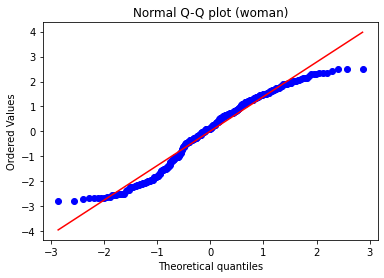

kolmogorv KstestResult(statistic=0.5687128810734844, pvalue=1.2533539369034309e-102)


In [61]:
check_normal_dist(df_NRC_woman, "arousal", "woman")

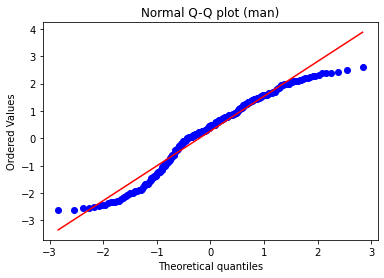

kolmogorv KstestResult(statistic=0.55815094306026, pvalue=1.37170136723303e-90)


In [62]:
check_normal_dist(df_NRC_man, "arousal","man")

In [63]:
def apply_welch_test(df_1,df_2,score_type):
    from scipy.stats import ttest_ind
    import math
    import statistics
   
    stat, p = ttest_ind(df_1[score_type].tolist(),df_2[score_type].tolist(), nan_policy="omit", alternative="two-sided",equal_var=False )#, equal_var=False)
    alpha = 0.05
    print("welsh")
    print("Statistics=%3f, p=%.3f" % (stat, p))
    if p < alpha:
        print("Different distributions (reject H0)")
    else:
        print("Same distribution (fail to reject H0)")
    if p < alpha:
        d = (df_1[score_type].mean() - df_2[score_type].mean())/math.sqrt(((df_1[score_type].var() + df_2[score_type].var())/2))
        
        print(d, "Cohens D")
    print(len(df_1), len(df_2))

In [64]:
apply_welch_test(df_NRC_woman, df_NRC_man,"arousal")
apply_welch_test(df_NRC_woman, df_NRC_man,"valence")
apply_welch_test(df_NRC_woman, df_NRC_man,"dominance")

welsh
Statistics=1.652739, p=0.099
Same distribution (fail to reject H0)
334 307
welsh
Statistics=-1.159042, p=0.247
Same distribution (fail to reject H0)
334 307
welsh
Statistics=-0.957850, p=0.339
Same distribution (fail to reject H0)
334 307


In [65]:
print(df_NRC_man["valence"].mean(),df_NRC_man["arousal"].mean(),df_NRC_man["dominance"].mean() )
print(df_NRC_woman["valence"].mean(),df_NRC_woman["arousal"].mean(),df_NRC_woman["dominance"].mean() )

0.5607654723127039 0.5105667752442998 0.5048631921824103
0.5377964071856285 0.5350299401197608 0.4923203592814373
